# 16. Predicting Personality Index (Frame selection)

In [1]:
from src import *
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import r2_score

In [3]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer
from sklearn.metrics import make_scorer

# Used for scoring argument in fold scoring
def pearson_corrscore(y_true, y_pred):
    ret = pearson_correlation(y_true, y_pred)
    return ret

scoring_method = make_scorer(pearson_corrscore, greater_is_better=True)

D = lambda x,y: ((x-y)**2).sum(axis=1)

In [4]:
# To deal with convergence warnings in sklearn, I know that some weighting search wont allow convergence !!!!!
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

## Description

We predict personality index from gradients

GOAL: Predicting personality index from gradients

## Table of Contents

- [On full movie Static Gradients](#staticgrad)
- [On frame selected Static Gradients](#fselect-staticgrad)



In [5]:
# Loading behavioural scores
behavioural  = pd.read_excel('./data/labels/Behavioural_PSY_scored.xlsx')
existing_psy = list(behavioural.columns[-15:])

regions      = list(index2region.keys())
print(regions)

['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default', 'Sub']


<a class="anchor" id="staticgrad"></a>
## On full movie Static Gradients

In [6]:
supermovie_grads = load('./resources/static_grad/individual_level/SUPERMOVIE_grad414.pkl')
rest_grads = load('./resources/static_grad/individual_level/Rest_grad414.pkl')

subjects = list(rest_grads.keys())
nsub = len(subjects)

supermovie_dist = {}
rest_dist = {}
for _id in subjects:
    # 1. Movie
    tmp_grads = supermovie_grads[_id]
    dist = D(tmp_grads.mean(axis=0), tmp_grads)
    supermovie_dist[_id] = dist
    
    # 2. Rest
    tmp_grads = rest_grads[_id]
    dist = D(tmp_grads.mean(axis=0), tmp_grads)
    rest_dist[_id] = dist

#### Visual difference

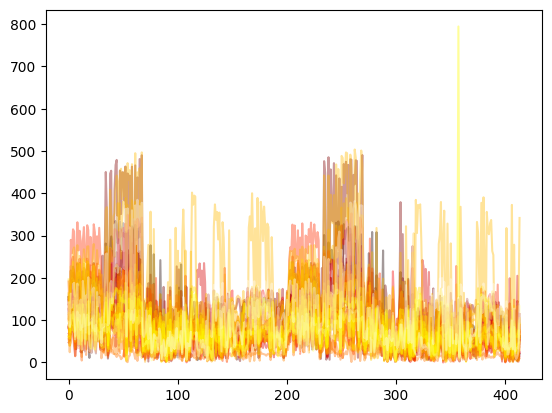

In [7]:
feat = 'cov_total'
psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]

# for Display
order = np.argsort(psyscore)
ordered_grads = [supermovie_dist[subj] for subj in subjects]
G, coloring = [],[]

colors = plt.cm.hot(np.linspace(0,1,int(max(psyscore))+1))
for i in order:
    plt.plot(np.arange(414), ordered_grads[i], color=colors[int(psyscore[i])], alpha=0.4)

#### Regress / Predictive

In [20]:
import os

In [26]:
os.path.abspath('./')

'/media/miplab-nas2/Data2/Movies_Emo/Michael/connectivity_gradient_analysis'

(array([ 3.,  2., 20., 35., 43., 60., 71., 36., 20.,  9.]),
 array([-0.67866422, -0.58298343, -0.48730264, -0.39162185, -0.29594106,
        -0.20026027, -0.10457948, -0.00889869,  0.0867821 ,  0.18246289,
         0.27814367]),
 <BarContainer object of 10 artists>)

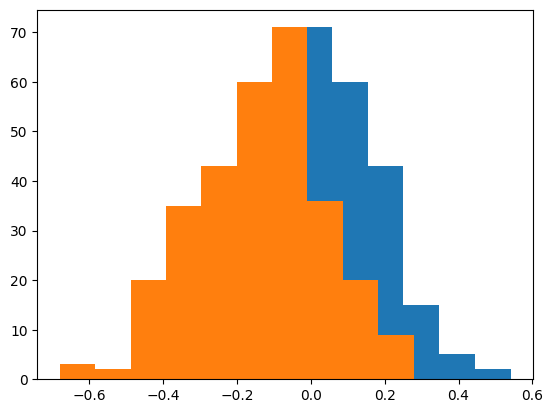

In [17]:
plt.hist(np.asarray(pred_corrs['movie']['bis']).mean(axis=1))
plt.hist(np.asarray(pred_corrs['rest']['bis']).mean(axis=1))

(array([ 3.,  6., 15., 33., 54., 66., 70., 42.,  6.,  5.]),
 array([-0.60280242, -0.48347563, -0.36414884, -0.24482205, -0.12549526,
        -0.00616847,  0.11315831,  0.2324851 ,  0.35181189,  0.47113868,
         0.59046547]),
 <BarContainer object of 10 artists>)

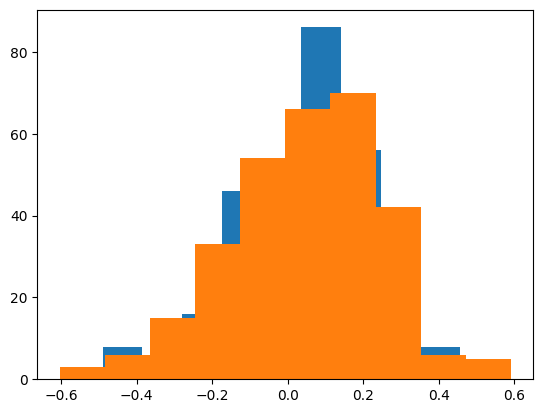

In [16]:
plt.hist(np.asarray(pred_corrs['movie']['cov_total']).mean(axis=1))
plt.hist(np.asarray(pred_corrs['rest']['cov_total']).mean(axis=1))

In [8]:
# across all pidx
pred_corrs = {"movie": {}, "rest":{}}
grads_dist = [supermovie_dist, rest_dist]
for gidx, gtype in enumerate(['movie', 'rest']):
    for feat in tqdm(existing_psy):
        psyscore = [behavioural[behavioural.ID == subjects[i]][feat].item() for i in range(len(subjects))]

        X = np.asarray([grads_dist[gidx][subj] for subj in subjects])
        y = np.array(deepcopy(psyscore))

        # https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
        n_iter = 300
        list_scores = []

        lambda_grid = [10**(i) for i in range(-3,4)] + [5] + [20] + [30] + [50]

        for k in range(n_iter):
            rs = k
            # configure the cross-validation procedure
            cv_inner = KFold(n_splits=4, shuffle=True, random_state=rs)
            # define the model
            model = Lasso()
            # define search space
            space = dict()
            space['alpha'] = lambda_grid
            # define search
            search = GridSearchCV(model, space, scoring=scoring_method, n_jobs=1, cv=cv_inner, refit=True)
            # configure the cross-validation procedure
            cv_outer = KFold(n_splits=3, shuffle=True, random_state=rs)
            # execute the nested cross-validation
            scores = cross_val_score(search, X, y, scoring=scoring_method, cv=cv_outer, n_jobs=-1)
            # report performance
            list_scores.append(scores)
        
        pred_corrs[gtype][feat] = list_scores

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

<a class="anchor" id="fselect-staticgrad"></a>
## On frame selected Static Gradients